In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import collections
import pandas as pd
from scipy.signal import find_peaks_cwt
from scipy.stats import linregress
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from pandas.stats.api import ols
import glob
#import pyupset
import itertools
import matplotlib
%matplotlib inline
matplotlib.rcParams['svg.fonttype'] = 'none'

from statsmodels.discrete.discrete_model import NegativeBinomial

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def return_samples(sample_type):
    samps = open('../samples.csv','r').read().split('\n')[1:60]
    #print samps[0]
    #print samps[0].split(',')
    if sample_type == 'bio':
        datasets = [samp.split(',')[6] for samp in samps if (samp.split(',')[8] == 'true' and samp.split(',')[4] == 'Construct' and samp.split(',')[6] != 'eisen_bact')]
    elif sample_type == 'sim':
        datasets = [samp.split(',')[6] for samp in samps if (samp.split(',')[8] == 'true' and samp.split(',')[4] == 'Sim' and samp.split(',')[6] != 'eisen_bact')]
    elif sample_type == 'full':
        datasets = [samp.split(',')[6] for samp in samps if samp.split(',')[8] == 'true' and samp.split(',')[6] != 'eisen_bact']
    elif sample_type == 'nanopore':
        datasets = ['b?'+ext for ext in ['.pass.2d','.fail.2d']]
    print '# datasets = ', len(datasets)
    #print 'dataset names = ', ','.join(datasets)
    return datasets

In [3]:
def tabulate(fi1,index,abundance_threshold=0):   
    fi = open(fi1).read().split('\n')
    di = {line.split()[0]:float(line.split()[index]) for line in fi
        if len(line.split()) > 3 and line.split()[index] != '' and float(line.split()[2])>abundance_threshold} 
    df = pd.DataFrame(di.items(), columns=['taxid', 'num']) 
    return df

In [4]:
def tabulate_nanopore(fis,index):   #mod for nanopore
    di = {}
    for fi in fis:
        fi = open(fi).read().split('\n')
        for line in fi:
            if len(line.split('\t')) > 3 and line.split('\t')[index] != '':
                if line.split('\t')[0] in di:
                    di[line.split('\t')[0]] += float(line.split('\t')[index])
                else:
                    di[line.split('\t')[0]] = float(line.split('\t')[index])
    df = pd.DataFrame(di.items(), columns=['taxid', 'num']) 
    df.sort_values(by='num',ascending=False,inplace=True)
    return df

In [5]:
def load_fis(datasets,file_dict,level,sample_type,abd_threshold):
    fis = collections.defaultdict(dict)
    #if sample_type == 'full':
        #print 'missing files:'
    no_truth = []
    for ds in datasets:
        for tool in file_dict:
            pref,suf = univ_pref+level+'/','_'+file_dict[tool]
            files = glob.glob(pref+'*'+ds+'*'+suf+'.txt')
            if len(files) == 0:
                files = glob.glob(pref+'*'+ds.lower()+'*'+suf+'.txt')
                #if len(files) == 0 and sample_type == 'full':
                    #print pref+'*'+ds+'*'+suf
            if len(files) == 1 and sample_type != 'nanopore':
                if tool == 'truth_set':
                    truth = tabulate(files[0],1)
                    if len(truth) > 0:
                        fis[ds][tool] = truth
                    elif sample_type != 'negative_control':
                        no_truth.append(ds)
                        break
                    #print ds, fis[ds][tool] #len(fis[ds][tool])
                else:
                    fis[ds][tool] = tabulate(files[0],1,abd_threshold) #change index to 2 for relative abundance?
            elif tool == 'truth_set' and sample_type != 'nanopore' and sample_type != 'negative_control':
                no_truth.append(ds)
                break
            elif sample_type == 'nanopore':
                fis[ds][tool] = tabulate_nanopore(files,2)
                
    if sample_type != 'negative_control':
        print 'no truth:', no_truth
        file_dict = {ds:fis[ds] for ds in fis if len(fis[ds]) > 0 and 'truth_set' in fis[ds] > 0}
        print 'truth:',file_dict.keys()
    else:
        file_dict = fis

    return file_dict

In [6]:
def overlap(df_list,inds,return_taxa=False):
    overlap_created = False
    for ind in inds:
        if len(df_list[ind])>0:
            if not overlap_created:
                overlap_set = set(df_list[ind])
                overlap_created = True
            else:
                overlap_set = overlap_set & set(df_list[ind])
        else:
            if return_taxa:
                return 0,set([])
            else:
                return 0
    try:
        if return_taxa:
            return len(overlap_set),overlap_set
        else:
            return len(overlap_set)
    except TypeError:
        if return_taxa:
            return 0,set([])
        else:
            return 0

In [7]:
def make_overlap_df(datasets,fis,tool_list,aupr_fi,fi_dict):
    overlap_dict = {'dataset':[],'tool':[],'truth_size':[],'measure':[],'value':[]}
    print 'no aupr'
    for ds in fis:
        if 'truth_set' in fis[ds]:
            truth = set(fis[ds]['truth_set'].taxid)
            for subset in itertools.combinations(tool_list, tool_num):
                list_taxids = [truth]
                for tool in subset:
                    if tool in fis[ds] and tool != 'truth_set':
                        list_taxids.append(set(fis[ds][tool].taxid))
                if len(list_taxids) == tool_num+1:       
                    total_positives = overlap(list_taxids,list(np.arange(1,tool_num+1)),False) 
                    tp,taxa = overlap(list_taxids,list(np.arange(0,tool_num+1)),True)
                    fp = total_positives - tp
                    if total_positives > 0:
                        precision = tp*100./total_positives
                    else:
                        precision = 0
                    if len(list_taxids[0]) > 0:
                        recall = tp*100./len(list_taxids[0])
                    else:
                        recall = 0
                    #print '+'.join([tool for tool in subset]), tp, total_positives, precision, recall
                    if not (precision == 0 and recall == 0):
                        f1 = 2*(precision*recall)/(precision+recall)
                    else:
                        f1 = 0
                    if aupr_fi != []:
                        toolname = file_dict[subset[0]]
                        try:
                            aupr = float(aupr_fi.split(toolname+'\t'+ds+'\t')[1].split('\n')[0])*100
                            mv = zip(['precision','recall','f1','aupr','fp_count'],[precision,recall,f1,aupr,fp])
                        except IndexError:
                            mv = zip(['precision','recall','f1','fp_count'],[precision,recall,f1,fp])
                            #print ds, tool
                        #print toolname, ds, aupr
                    else:
                        mv = zip(['precision','recall','f1','fp_count'],[precision,recall,f1,fp])
                    for measure,value in mv: 
                        overlap_dict['dataset'].append(ds)
                        overlap_dict['tool'].append('+'.join(sorted([tool for tool in subset])))
                        overlap_dict['truth_size'].append(len(list_taxids[0]))
                        overlap_dict['measure'].append(measure)
                        overlap_dict['value'].append(value) 
    overlap_df = pd.DataFrame(overlap_dict)
    return overlap_df

In [8]:
def add_mean(df):
    for measure in set(df.measure):
        colname = measure + '_mean'
        col = {}
        subdf = df[df.measure == measure]
        for tool in set(df.tool):
            subsubdf = subdf[subdf.tool == tool]
            col[tool] = np.mean(subsubdf.value)
        df[colname] = [col[tool] for tool in df.tool]
    return df

In [9]:
def save_boxplot(fig,plot_title):
    plt.xticks(rotation=90)
    plt.tight_layout()
    save_figtypes(fig, plot_title)
    plt.show()
    #for ext in ['.pdf','.png']:
    #    plt.savefig(plot_title+ext,format=ext.split('.')[1],dpi=500) 

In [10]:
def save_figtypes(fig,plot_title):
    for ext in ['.pdf','.png']:
        fig.savefig(plot_title+ext,format=ext.split('.')[1],dpi=500,bbox_inches='tight',transparent=True)     

In [11]:
def plot_boxplots(num_tools, overlapDF):
    sns.set(style="ticks",font_scale=1.5)
    sns.set_palette(['#ec1c58','#9BF3F0','#C2E812','#40F99B'])
    sns.despine()
    if len(set(overlapDF.tool)) > 20:
        for mej in set(overlapDF.measure):
            if num_tools == 'paired':
                fig = plt.figure() #figsize=(8,5))
                sz = 8.2 
                asp = 1.8
                fs = 1
            else:
                fig = plt.figure() #figsize=(20,15))
                sz = 20
                asp = 1.5
                fs = 0.4
            with sns.plotting_context(font_scale=fs):
                sns.factorplot(x='tool',y='value',hue='measure',data=overlapDF.sort_values('precision_mean',ascending=False)[overlapDF.measure == mej],kind='box',hue_order=['f1','precision','recall'],size=sz,aspect=asp,legend=False)   
            print 'highest mean ' + mej + ':'
            print overlapDF.sort_values(mej+'_mean',ascending=False)[overlapDF.measure == mej].head(1)
            #if tool_num > 1:
            plt.xlabel('')
            plt.ylabel(mej)
            plt.title(level,fontweight="bold",y=1.08)
            plot_title = num_tools+'_comp_'+level+'_'+sample_type+'_'+mej
            fig1 = plt.gcf()
            save_boxplot(fig1, plot_title)
    else:
        if len(set(overlapDF.tool)) < 10:
            fs = 8.2
            asp = 1
        else:
            fs = 6
            asp = 2
        fig = plt.figure()
        #print overlapDF[["tool","precision_mean","recall_mean","f1_mean"]].drop_duplicates()
        sns.factorplot(x='tool',y='value',hue='measure',data=overlapDF.sort_values('f1_mean',ascending=False),kind='box',hue_order=['f1','precision','recall','aupr'],size=fs,aspect=asp,legend_out=False)
        plot_title = num_tools+'_comp_'+level+'_'+sample_type
        plt.xlabel('')
        plt.ylabel('percent')
        plt.title(level,fontweight="bold", y=1.08)
        plt.legend(bbox_to_anchor=(1, 1), loc=2)
        fig1 = plt.gcf()
        save_boxplot(fig1, plot_title)

In [12]:
def write_venn(ds_dict,tool_list,size,vennfi): 
    outfi = open(vennfi+'_size'+str(size)+'.jsonp','w')
    outfi.write('var sets = [')
    tool_num = {}
    for num_tools in range(1,len(tool_list)+1):
        for subset in itertools.combinations(tool_list,num_tools):
            if num_tools == 1:
                tool_num[subset[0]] = len(tool_num)
                addition = ', "label": "'+subset[0]+'", "size": '
            else:
                addition = ', "size": '
            if num_tools != len(tool_list):
                ext = '},'
            else:
                ext = '}];'
            ov = overlap([ds_dict[subset[x]].taxid.head(size) if subset[x] != 'truth_set' else ds_dict[subset[x]].taxid for x in range(num_tools)],np.arange(0,num_tools))
            print subset, ov
            outfi.write('\n\t{"sets": ['+','.join([str(tool_num[tool]) for tool in subset])+']'+addition+str(ov)+ext)
    outfi.close()

In [13]:
def add_dataset_size(df):
    df['dataset_size'] = [x+' ('+str(y)+')' for x,y in zip(list(df.dataset),list(df.truth_size))]
    return df

In [14]:
def find_agreement(tool_list,fis,tool_list2=None):
    agree_dict = {'dataset':[],'truth_size':[],'comp_size':[],'percent_agreement':[]}
    tool_dict = {'dataset':[],'truth_size':[],'tool_size':[],'tool':[]}
    for ds in fis:
        if 'truth_set' in fis[ds]:
            truth = fis[ds]['truth_set']
            for size in range(1,120):
                taxid_list = []
                for tool in tool_list:
                    if tool != 'truth_set' and tool in fis[ds] :
                        #print tool
                        taxid_df = fis[ds][tool]
                        taxid_list.append(set(taxid_df.sort_values('num',ascending=False).head(size)['taxid']))
                perc_agreement = (100.0*overlap(taxid_list,np.arange(0,len(taxid_list))))/size 
                agree_dict['dataset'].append(ds)
                agree_dict['truth_size'].append(len(truth))
                agree_dict['comp_size'].append(size)
                agree_dict['percent_agreement'].append(perc_agreement)
                if tool_list2:
                    for tool in tool_list2:
                        if tool != 'truth_set' and tool in fis[ds] :
                            tool_dict['dataset'].append(ds)
                            tool_dict['tool'].append(tool)
                            tool_dict['truth_size'].append(len(truth))
                            tool_dict['tool_size'].append(len(fis[ds][tool]))                        
    agree_df = pd.DataFrame(agree_dict)
    return agree_df,tool_dict

In [15]:
def plot_percent_agreement(agree_df,level):
    sns.set_style('ticks')
    sns.despine()
    sns.set_palette(sns.cubehelix_palette(40, start=.5, rot=5, hue=1, light=0.2, dark=0.7))
    agree_df = add_dataset_size(agree_df)
    #agree_df.sort_values(by='truth_size',inplace=True)
    agplot = sns.factorplot(x='comp_size',y='percent_agreement',hue='dataset_size',markers='.',
              data=agree_df,size=10,aspect=1.5,legend=False)
    agplot.set(xlabel='comparison size (# top species)',ylabel='percent agreement',xticks=np.arange(0,120,5),
          xticklabels=np.arange(0,200,5),ylim=(-1,100))
    ds_sizes = list(agree_df.sort_values(by='truth_size').drop_duplicates(subset='dataset')['dataset_size'])
    agplot.add_legend(label_order=ds_sizes,title='# taxa\n in sample')
    plot_title = 'percent_agreement_'+level
    save_figtypes(agplot, plot_title)

In [16]:
def find_peaks(zip_list,threshold):
    letzte = zip_list[2:-2]
    letzte1 = zip(list(np.asarray([x[0]+threshold for x in zip_list[1:-3]])), [x[1] for x in zip_list[1:-3]]) 
    letzte2 = zip(list(np.asarray([x[0]+threshold*2 for x in zip_list[:-4]])), [x[1] for x in zip_list[:-4]]) 
    nachste = zip(list(np.asarray([x[0]+threshold for x in zip_list[4:]])), [x[1] for x in zip_list[4:]])
    peaks = [x[0] for x in zip(zip_list[3:-1],letzte,letzte1,nachste,letzte2) if all([x[0][0]>x[i][0] for i in range(1,5)])]
    if len(peaks) == 0:
        """peak len 0-1"""
        if zip_list[1][0] > zip_list[0][0]:
            peaks = [zip_list[1]]
        else:
            peaks = [zip_list[0]]
    #print peaks
    return peaks

In [17]:
def plot_last_peak(agreement_df):
    """plot last peak vs. truth size"""
    truth_peak_dict = {'truth_size':[],'last peak':[]}
    sns.set_palette(['#044389','#7AE7C7','#5995ED','#EC0B43','#FFAD05','#58355E','#FCFF4B','#D6FFB7','#FFF689','#7CAFC4'])
    agree_df = agreement_df[agreement_df.truth_size < 120]
    for ds in set(agree_df.dataset):
        subpd = agree_df[agree_df['dataset'] == ds]
        comp_size_peaks = find_peaks(zip(list(subpd['percent_agreement']),list(subpd['comp_size'])),0.5)
        max_peak = list(subpd[subpd['percent_agreement'] == max(subpd['percent_agreement'])]['comp_size'])[0]
        truth_peak_dict['truth_size'].append(list(subpd['truth_size'])[0])
        truth_peak_dict['last peak'].append(max(comp_size_peaks[-1][1],max_peak))
        #break
    truth_peak_df = pd.DataFrame(truth_peak_dict)
    fig = sns.lmplot(x='truth_size',y='last peak',data=truth_peak_df,size=4.2)
    plt.xlabel('# species in truth set')
    fig.set(ylim=(0,120),xlim=(0,120))
    save_figtypes(fig,'size_vs_peak')
    rmse = np.sqrt(np.mean((truth_peak_df['last peak']-truth_peak_df['truth_size'])**2))
    slope, intercept, r_value, p_value, std_err = linregress(truth_peak_df['truth_size'],truth_peak_df['last peak'])
    print 'R value =',r_value, ', p value =',p_value, ', RMSE =',rmse

In [18]:
def plot_num_hits(tool_dict):
    """plot # positives by tool vs. truth size"""
    tool_dataframe = pd.DataFrame(tool_dict)
    tool_df = tool_dataframe[tool_dataframe.truth_size < 120]
    tool_df.sort_values(by='tool',ascending=True,inplace=True)
    pal = [colour_dict[tool] for tool in sorted(list(set(tool_df.tool)))]
    fig = sns.lmplot(x='truth_size',y='tool_size',data=tool_df,hue='tool',size=4.2,aspect=1.1,palette=pal)
    plt.xlabel('# species in truth set')
    plt.ylabel('# species identified')
    fig.set(ylim=(0,120),xlim=(0,120))
    save_figtypes(fig,'size_vs_tool')
    for tool in set(tool_df.tool):
        rmse = np.sqrt(np.mean((tool_df[tool_df.tool == tool]['tool_size']-tool_df[tool_df.tool == tool]['truth_size'])**2))
        slope, intercept, r_value, p_value, std_err = linregress(tool_df[tool_df.tool == tool]['truth_size'],tool_df[tool_df.tool == tool]['tool_size'])
        print tool, r_value, p_value, rmse

In [1]:
univ_pref = ''
score_dir = '../score_precision_recall/output/'
file_dict = {'DiamondMegan_filtered':'DiamondMegan',
             'CLARK':'ClarkM1Default',
             'CLARK-S':'ClarkM4Spaced',
             #'CosmosID':'CosmosID',
             #'CosmosID_filtered':'CosmosIDFiltered',
             'Kraken':'Kraken', 
             'Kraken_filtered':'KrakenFiltered',
             'PhyloSift':'PhyloSift',
             'PhyloSift_filtered':'PhyloSift90pct',
             'MetaPhlAn':'Metaphlan',
             'LMAT':'LMAT',
             'GOTTCHA':'Gottcha',
             'GOTTCHA-strain':'Gottcha-strain',
             'MetaFlow':'MetaFlow',
             'Community':'COMMUNITY',
             #'BlastEnsemble':'bmfmetagotlmat-average',
             #'DiamondEnsemble':'diakrametagotlmat-average',
             #'DiamondMegan_filtered+Kraken_filtered':'DiamondMeganKrakenFiltered',
             #'BlastMegan_filtered+LMAT':'BlastMeganFilteredLMAT',
             #'CLARK+GOTTCHA':'ClarkM1DefaultGottcha',
             #'MetaPalette':'_MetaPallette-SmallDB-qual4-default.txt',
             #'MetaPalette_specific':'_MetaPallette-SmallDB-qual4-specific.txt',
             #'OneCodex':'OneCodexAbundance',
             #'OneCodex_filtered':'OneCodexAbundanceFiltered',
             'BlastMegan_filtered':'BlastMeganFiltered',
             'BlastMegan_filtered_liberal':'BlastMeganFilteredLiberal',
             'NBC':'NBC',
             #'Kraken_miniDB':'KrakenMiniDB',
             #'Kraken_miniDB_filtered':'KrakenMiniDBFiltered',
             #'DiamondSensitiveMegan_filtered':'DiamondMegan_sensitive',
             'truth_set':'TRUTH'
             }
lot = ['BlastMegan_filtered','DiamondMegan_filtered','Kraken_filtered','Kraken','PhyloSift','GOTTCHA-strain',
       'BlastMegan_filtered_liberal','CLARK','MetaPhlAn','LMAT','NBC','PhyloSift_filtered','CLARK-S',
       'GOTTCHA','MetaFlow']
diamond_list = ['DiamondSensitiveMegan_filtered','DiamondMegan_filtered']
kraken_list = ['Kraken_miniDB','Kraken_miniDB_filtered','Kraken','Kraken_filtered']
shorter_tool_list = ['BlastMegan_filtered','DiamondMegan_filtered','Kraken_filtered',
                     'CLARK','MetaPhlAn','LMAT','NBC','PhyloSift_filtered','CLARK-S','GOTTCHA','MetaFlow']
ensemble_tool_list = ['Community','BlastEnsemble','DiamondMegan_filtered','DiamondEnsemble','BlastMegan_filtered',
                      'GOTTCHA','GOTTCHA-strain','DiamondMegan_filtered+Kraken_filtered','BlastMegan_filtered+LMAT',
                      'CLARK+GOTTCHA']

abundance_threshold = -10 #0.0001


In [31]:
colour_dict = {'DiamondMegan_filtered':(190,190,190),
             'CLARK':(178,223,138),
             'CLARK-S':(51,160,44),
             'CosmosID':(227,26,28),
             'CosmosID_filtered':(251,154,153),
             'Kraken':(255,127,0), 
             'Kraken_filtered':(253,191,111),
             'PhyloSift':(102,205,0),
             'PhyloSift_filtered':(127,255,0),
             'MetaPhlAn':(148,0,211),
             'LMAT':(176,48,96),
             'GOTTCHA':(106,61,154),
             'MetaFlow':(177,89,40),
             'Community':(0,0,0),
             'OneCodex_filtered':(202,178,214),
             'BlastMegan_filtered':(166,),
             'BlastMegan_filtered_liberal':(31,120,180),
             'NBC':(255,0,255)}
for tool in colour_dict:
    colour_dict[tool] = tuple(map(lambda x: x/255., colour_dict[tool]))

## Figures 1 and 4


SAMPLE TYPE: full

# datasets =  35

LEVEL: subspecies
no truth: ['eval_carma', 'eval_RAIphy', 'even_454_SRR072233', 'even_illum_SRR172902', 'HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8', 'MGRG_1ng', 'MGRG_5ng', 'MGRG_10ng', 'MGRG_Half', 'MGRG_Normal', 'simHC', 'simLC', 'simMC', 'BioPool']
truth: ['ds.buccal', 'ds.soil', 'SRR033547', 'ds.nycsm', 'SRR033549', 'ds.hous1', 'ds.7', 'SRR033548', 'ds.cityparks', 'bmi_reads', 'ds.hous2', 'ds.gut']
# datasets =  12
no aupr


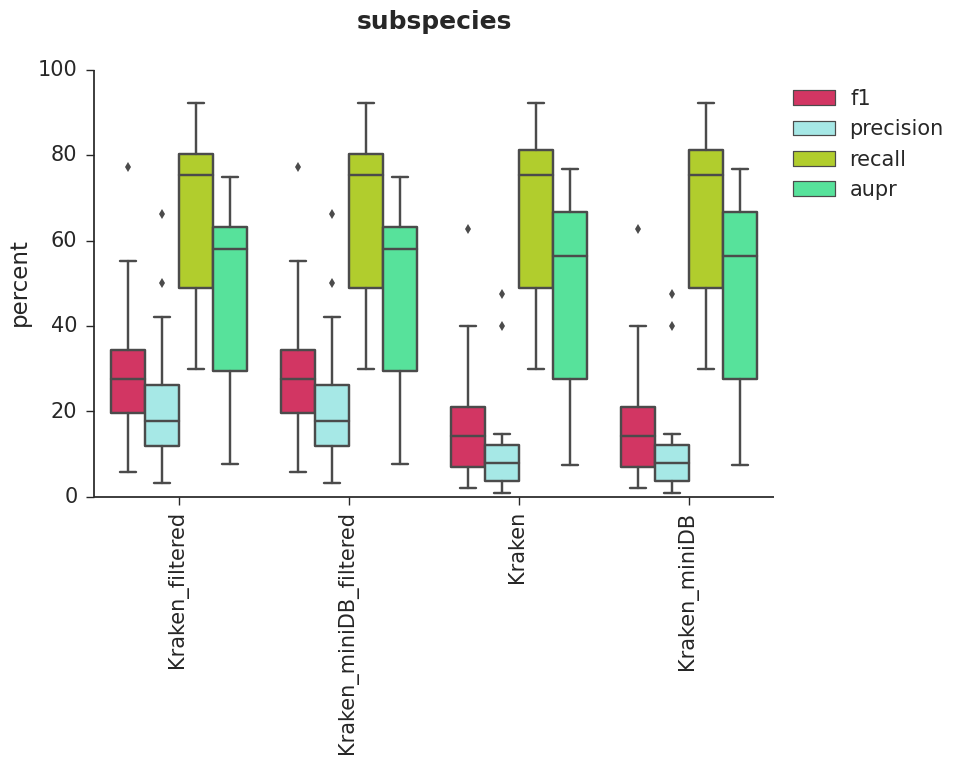


LEVEL: genus
no truth: []
truth: ['LC6', 'LC7', 'LC4', 'LC5', 'LC2', 'LC3', 'MGRG_Normal', 'MGRG_10ng', 'LC8', 'even_illum_SRR172902', 'MGRG_5ng', 'ds.gut', 'HC2', 'HC1', 'ds.hous1', 'ds.7', 'LC1', 'BioPool', 'simLC', 'simHC', 'MGRG_1ng', 'MGRG_Half', 'eval_RAIphy', 'eval_carma', 'ds.buccal', 'ds.soil', 'SRR033547', 'even_454_SRR072233', 'simMC', 'SRR033548', 'ds.nycsm', 'SRR033549', 'ds.cityparks', 'ds.hous2', 'bmi_reads']
# datasets =  35
no aupr


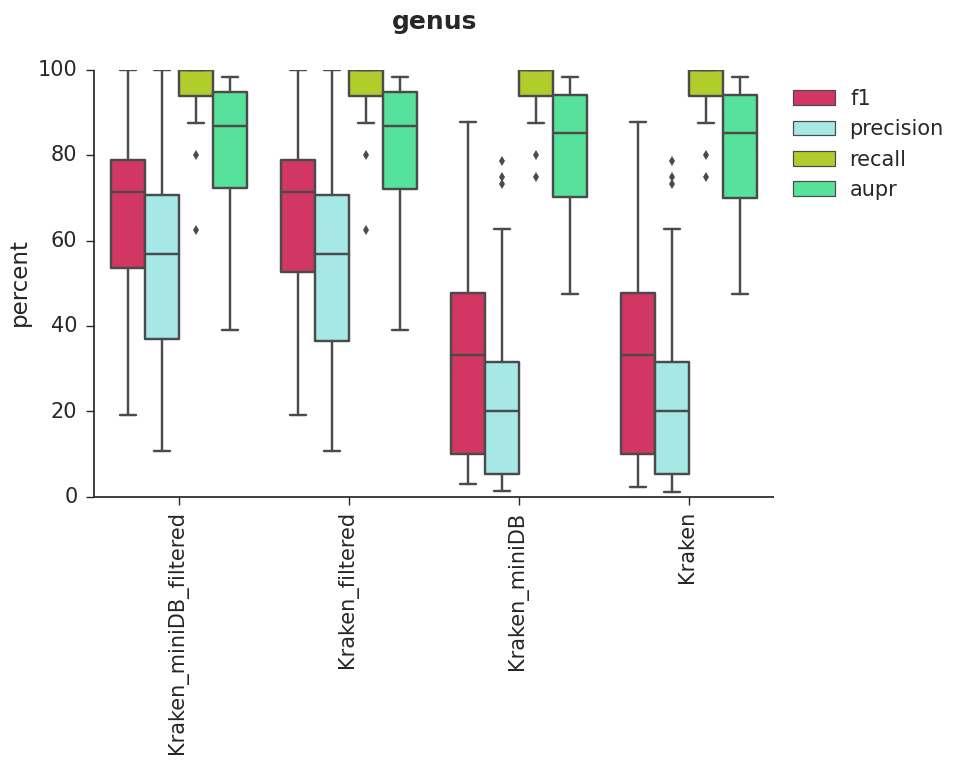


LEVEL: species
no truth: []
truth: ['LC6', 'LC7', 'LC4', 'LC5', 'LC2', 'LC3', 'MGRG_Normal', 'MGRG_10ng', 'LC8', 'even_illum_SRR172902', 'MGRG_5ng', 'ds.gut', 'HC2', 'HC1', 'ds.hous1', 'ds.7', 'LC1', 'BioPool', 'simLC', 'simHC', 'MGRG_1ng', 'MGRG_Half', 'eval_RAIphy', 'eval_carma', 'ds.buccal', 'ds.soil', 'SRR033547', 'even_454_SRR072233', 'simMC', 'SRR033548', 'ds.nycsm', 'SRR033549', 'ds.cityparks', 'ds.hous2', 'bmi_reads']
# datasets =  35
no aupr


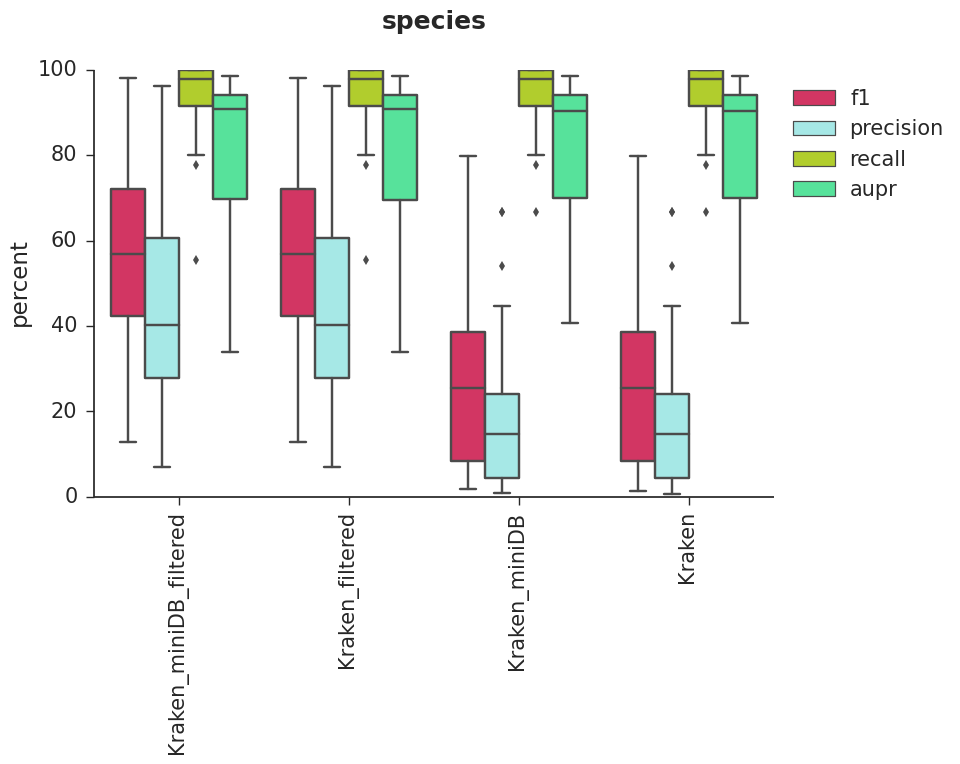

In [ ]:
overlapDF = {}
high_ppv_overlap_set = {}
for sample_type in ['bio','sim','full']:
    
    print '\nSAMPLE TYPE: ' + sample_type + '\n'
    datasets = return_samples(sample_type)
    if sample_type == 'full':
        level_list = zip([2,0,1],['subspecies','genus','species']) #genus = 0, species = 1, strain = 2
    else:
        level_list = zip([1],['species'])
    
    for lev,level in level_list: 
        
        print '\nLEVEL: ' + level
        if (lev < 2) and sample_type == 'full': # or lev == 0
            #tool_sets = zip([1,2,3],['single','paired','tripled'])[2:]
            tool_sets = zip([1,2],['single','paired'])
        else:
            tool_sets = zip([1],['single'])
        fis = load_fis(datasets,file_dict,level,sample_type,abundance_threshold)
        print '# datasets = ', len(fis)
        
        for tool_num,num_tools in tool_sets:
            
            if tool_num > 1:
                #continue
                tool_list = shorter_tool_list
                #print shorter_tool_list
                aupr_fi = []
            else:
                tool_list = lot #kraken_list #diamond_list #ensemble_tool_list
                if lev == 2:
                    try:
                        tool_list.remove('CLARK')
                        tool_list.remove('CLARK-S')
                        tool_list.remove('MetaFlow')
                        tool_list.remove('GOTTCHA')
                    except ValueError:
                        pass
                else:
                    try:
                        tool_list.remove('GOTTCHA-strain')
                    except ValueError:
                        pass
                try:
                    aupr_fi = open(score_dir+level+'_AUPR.txt','r').read()
                except IOError:
                    aupr_fi = []
            overlapDF[(sample_type,level,tool_num)] = make_overlap_df(datasets,fis,tool_list,aupr_fi,file_dict)
            overlapDF[(sample_type,level,tool_num)] = add_mean(overlapDF[(sample_type,level,tool_num)])
            currentDF = overlapDF[(sample_type,level,tool_num)]
            #print currentDF
            plot_boxplots(num_tools, currentDF) 
            if tool_num == 2:
                if sample_type == 'full':
                    #print overlapDF.head()
                    thresh = 95
                    high_ppv_overlap_set[level] = set(currentDF[currentDF.precision_mean > thresh].tool)
                    print '# pairs with mean precision > '+str(thresh)+' =',len(high_ppv_overlap_set[level])
                    print 'BLAST-MEGAN+NBC',currentDF[currentDF.tool == 'BlastMegan_filtered+NBC'].loc[:,'recall_mean':].head(1)
            #elif tool_num == 1 and lev == 1 and sample_type == 'full':
                #for tool_print in ('Ensemble','BlastMegan_filtered','CosmosID_filtered','OneCodex','NBC','CLARK','Kraken_filtered'):
                    #print tool_print,currentDF[currentDF.tool == tool_print].loc[:,'recall_mean':].head(1)

In [38]:
#bm = set([x[0] for x in overlapDF[('full','species',1)][overlapDF[('full','species',1)].tool=='BlastMegan_filtered'][['dataset']].drop_duplicates().values])  
m = set([x[0] for x in overlapDF[('full','species',1)][overlapDF[('full','species',1)].tool=='BlastEnsemble'][['dataset','precision_mean']].drop_duplicates().values])
#bm - m

In [37]:
currentDF[currentDF.dataset == 'MGRG_1ng']

,dataset,measure,tool,truth_size,value,aupr_mean,recall_mean,precision_mean,fp_count_mean,f1_mean
360,MGRG_1ng,precision,Kraken_miniDB,5,1.037344,NaN,94.369486,18.595562,257.114286,27.672958
361,MGRG_1ng,recall,Kraken_miniDB,5,100.000000,NaN,94.369486,18.595562,257.114286,27.672958
362,MGRG_1ng,f1,Kraken_miniDB,5,2.053388,NaN,94.369486,18.595562,257.114286,27.672958
363,MGRG_1ng,fp_count,Kraken_miniDB,5,477.000000,NaN,94.369486,18.595562,257.114286,27.672958
364,MGRG_1ng,precision,Kraken_miniDB_filtered,5,16.666667,NaN,93.945216,44.769919,45.342857,56.626810
365,MGRG_1ng,recall,Kraken_miniDB_filtered,5,100.000000,NaN,93.945216,44.769919,45.342857,56.626810
366,MGRG_1ng,f1,Kraken_miniDB_filtered,5,28.571429,NaN,93.945216,44.769919,45.342857,56.626810
367,MGRG_1ng,fp_count,Kraken_miniDB_filtered,5,25.000000,NaN,93.945216,44.769919,45.342857,56.626810
368,MGRG_1ng,precision,Kraken,5,0.739645,82.996503,94.369486,18.547442,283.228571,27.579066
369,MGRG_1ng,recall,Kraken,5,100.000000,82.996503,94.369486,18.547442,283.228571,27.579066


In [51]:
overlapDF[('full','species',1)][['tool','aupr_mean']].drop_duplicates().values

array([['Community', 85.94981927228326],
       ['BlastEnsemble', 83.7461259462934],
       ['DiamondMegan_filtered', 71.88113848929508],
       ['DiamondEnsemble', 84.06274740817095],
       ['BlastMegan_filtered', 80.01562771463402],
       ['GOTTCHA', 76.65636302159105],
       ['DiamondMegan_filtered+Kraken_filtered', 68.0886048062633],
       ['BlastMegan_filtered+LMAT', 78.34428422896724],
       ['CLARK+GOTTCHA', 75.91293029015974]], dtype=object)

In [37]:
[x for x in overlapDF[('full','species',2)][['tool','precision_mean']].drop_duplicates().values.tolist() if x[1]>95]

[['BlastMegan_filtered+DiamondMegan_filtered', 96.6056166056166],
 ['BlastMegan_filtered+OneCodex_filtered', 98.15295815295815],
 ['BlastMegan_filtered+NBC', 95.90859099442247],
 ['BlastMegan_filtered+GOTTCHA', 95.13460833708208],
 ['DiamondMegan_filtered+GOTTCHA', 95.80035044320759],
 ['GOTTCHA+OneCodex_filtered', 95.95053238686779]]

In [95]:
len([x for x in overlapDF[('full','genus',2)][['tool','precision_mean']].drop_duplicates().values.tolist() if x[1]>95])

17

In [62]:
ovDF = overlapDF[('full','species',1)]
toSaveDF = ovDF[ovDF['measure'].isin(set(['precision','recall']))][['dataset','measure','tool','value']].drop_duplicates()
toSaveDF.head()
toSaveDF = pd.pivot_table(toSaveDF,index=['dataset','measure'],columns=['tool'],values='value')
#toSaveDF.head()
toSaveDF.to_csv('species_scores.csv')

## Figure 2

In [37]:
def scatter_ds_feature(feature,fps,feature_name,tool):
    fig = plt.figure(figsize=(3.5,3.5))
    x = feature
    plt.scatter(feature,fps,color='b')
    #for point in range(len(x)):
        #plt.text(x[point]+1,precisions[point]+1,datasets[point])
    plt.ylabel('false positives')
    plt.xlabel(feature_name, labelpad=20)
    plt.xlim([0,max(x)+max(x)/20])
    plt.ylim([0,max(fps)+(max(fps)/10)])
    sns.despine()
    plt.title(tool)
    fig = plt.gcf()
    save_figtypes(fig,tool+'_'+'_'.join(feature_name.split('(')[0].split())+'_scatter')

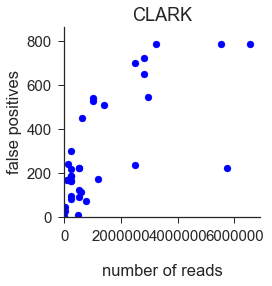

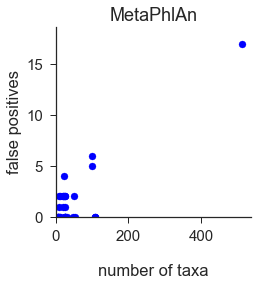

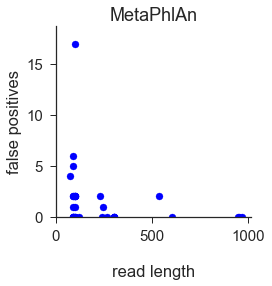

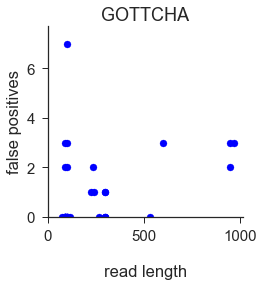

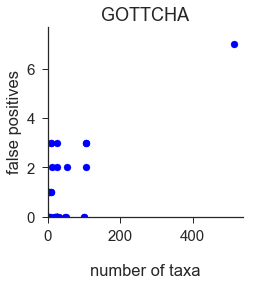

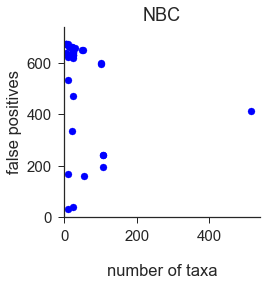

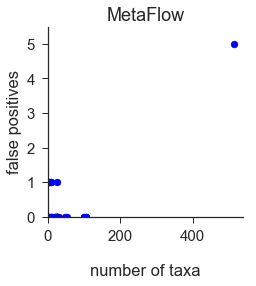

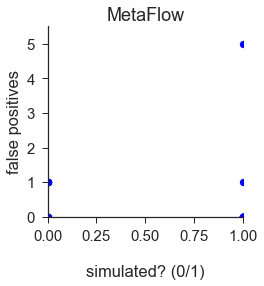

In [38]:
truthDF = pd.read_csv('../samples.csv')

Xlist = ['intercept','n_reads','n_taxa','read_len','sim'] #,'metaph'
Xlist_pretty = ['intercept','number of reads','number of taxa','read length','simulated? (0/1)'] #,'metaphlan dataset (0,1)'
tDict = {'tool':[],'measure':[],'coefficient':[],'p_val':[]}
#print 'Tools with significant F-stats:'
ovDF = overlapDF[('full','species',1)]

for tool in set(ovDF.tool): #['PhyloSift']
    subdf = ovDF[(ovDF.tool == tool) & (ovDF.measure == 'fp_count')]
    fps = list(subdf.value)
    n_reads = []
    n_taxa = []
    read_len = []
    sims = []
    cosmos = []
    datasets = []
    #metaphlan = []
    for row in range(len(subdf)):
        ds = subdf.iloc[row].dataset
        nr = int(truthDF[truthDF.sample_tag == ds].n_reads)
        nt = int(subdf.iloc[row].truth_size)
        rl = int(truthDF[truthDF.sample_tag == ds].read_len)
        #mt = int(truthDF[truthDF.sample_tag == ds].metaphlan)
        if truthDF[truthDF.sample_tag == ds].type.values[0] == 'Sim':
            sim = 1
        else:
            sim = 0 
        #ci = float(truthDF[truthDF.sample_tag == ds].cosmos)
        n_reads.append(nr)
        n_taxa.append(nt)
        read_len.append(rl)
        sims.append(sim)
        #cosmos.append(ci)
        datasets.append(ds)
        #metaphlan.append(mt)
    if tool == 'NBC':
        scatter_ds_feature(n_taxa,fps,Xlist_pretty[2],'NBC')
    if tool == 'CLARK':
        scatter_ds_feature(n_reads,fps,Xlist_pretty[1],'CLARK')
    if tool == 'MetaFlow':
        scatter_ds_feature(n_taxa,fps,Xlist_pretty[2],'MetaFlow')
    if tool == 'MetaFlow':
        scatter_ds_feature(sims,fps,Xlist_pretty[4],'MetaFlow')
    if tool == 'MetaPhlAn':
        scatter_ds_feature(n_taxa,fps,Xlist_pretty[2],'MetaPhlAn')
    if tool == 'MetaPhlAn':
        scatter_ds_feature(read_len,fps,Xlist_pretty[3],'MetaPhlAn')
    if tool == 'GOTTCHA':
        scatter_ds_feature(read_len,fps,Xlist_pretty[3],'GOTTCHA')
    if tool == 'GOTTCHA':
        scatter_ds_feature(n_taxa,fps,Xlist_pretty[2],'GOTTCHA')
    #if tool == 'MetaPhlAn':
        #scatter_ds_feature(metaphlan,precisions,Xlist_pretty[-1],tool)
        
    Xy = pd.DataFrame({"fps":fps,"n_reads":n_reads,"n_taxa":n_taxa,"read_len":read_len,"sim":sims})
    Xy.to_csv(tool+'_nb.csv')
    """Xy["constant"] = np.mean(fps) #"metaph":metaphlan
    nb = sm.NegativeBinomial(endog=Xy.fps, exog=Xy[Xlist])
    try:
        res_nbin = nb.fit(maxiter=100) 
    except: # LinAlgError:
        continue
    print tool,'\n',res_nbin.summary() 
    #break
    #res = ols(y=Xy.fps, x=Xy[Xlist])
    for xi in range(len(Xlist)):
        tDict['measure'].append(Xlist_pretty[xi])
        tDict['coefficient'].append(res_nbin._results.tvalues[xi])
        tDict['p_val'].append(res_nbin._results.pvalues[xi])
        tDict['tool'].append(tool)
    #print res
    #if res.f_stat['p-value'] < 0.05:
    #    print tool"""

In [26]:
#AFTER RUNNING R SCRIPT TO CALCULATE NEGATIVE BINOMIAL REGRESSIONS:
tDict = {'tool':[],'measure':[],'coefficient':[],'p_val':[]}
for tool in set(ovDF.tool): 
    results = pd.read_csv(tool+'_nbcoefs.csv')
    for xi in range(1,len(Xlist)):
        tDict['measure'].append(Xlist_pretty[xi])
        tDict['coefficient'].append(results["z value"][xi])
        tDict['p_val'].append(results["Pr(>|z|)"][xi])
        tDict['tool'].append(tool)

    coefficient           measure     p_val                         tool
12     2.485589   number of reads  0.012934  BlastMegan_filtered_liberal
14     2.711896       read length  0.006690  BlastMegan_filtered_liberal
16     3.467562   number of reads  0.000525                        CLARK
36     2.791261   number of reads  0.005250                      CLARK-S
29     2.027051    number of taxa  0.042657                      GOTTCHA
30     3.114577       read length  0.001842                      GOTTCHA
32     4.625203   number of reads  0.000004                       Kraken
34     2.034402       read length  0.041911                       Kraken
8      3.769499   number of reads  0.000164              Kraken_filtered
11     2.143714  simulated? (0/1)  0.032056              Kraken_filtered
48     3.712213   number of reads  0.000205                         LMAT
53     3.012926    number of taxa  0.002587                     MetaFlow
55    -2.251057  simulated? (0/1)  0.024382        

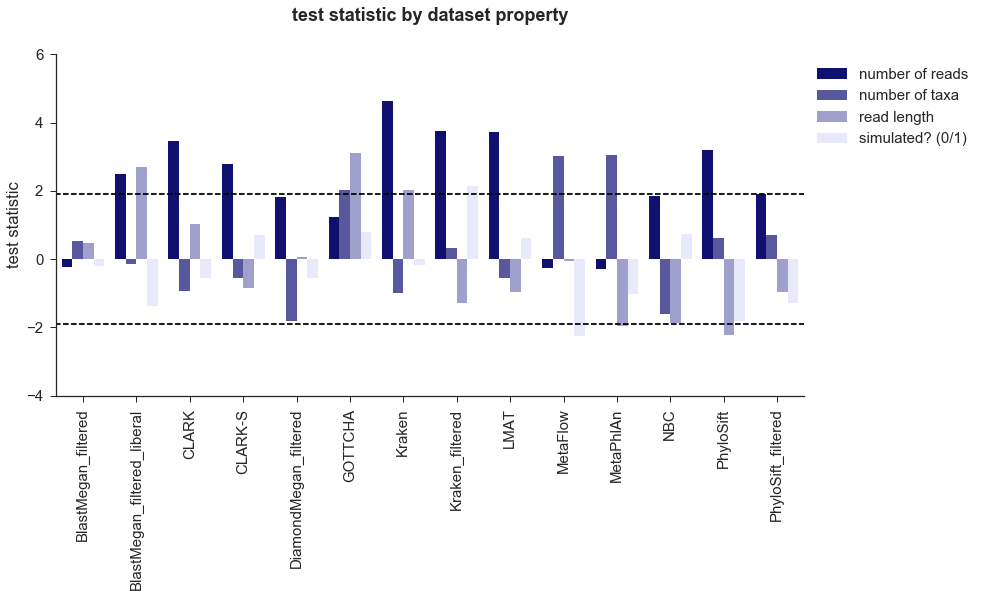

In [27]:
tDF = pd.DataFrame(tDict)
fig = plt.figure() 
sz = 6
asp = 2
fs = 0.5
tDF_sort = tDF.sort_values(['tool','measure'],ascending=[True,True])

with sns.plotting_context(font_scale=fs):
    sns.factorplot(x='tool',y='coefficient',hue='measure',data=tDF_sort,kind='bar',size=sz,aspect=asp,legend=False,palette=sns.light_palette("navy", 4, reverse=True)) 

ax = plt.gca()

sig_ps = tDF_sort.loc[tDF_sort['p_val']<0.05]
print sig_ps

p_thresh = 1.9
plt.plot([-10,20],[p_thresh,p_thresh],'--',color='k')
plt.plot([-10,20],[-p_thresh,-p_thresh],'--',color='k')
plt.ylim([-4,6])
plt.xlabel('')
plt.ylabel('test statistic')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.title('test statistic by dataset property',fontweight="bold",y=1.08)
plt.xticks(rotation=90)
fig = plt.gcf()
save_figtypes(fig,'falsepositives_by_dataset_feature')

In [49]:
#print tool,'\n',res_nbin.summary() 
#sm.tools.tools.add_constant(Xy[Xlist])

In [43]:
overlapDF[('full','species',2)][overlapDF[('full','species',2)].tool=='CLARK+Kraken_filtered'].loc[:,'recall_mean':].head(1)

,recall_mean,precision_mean,f1_mean
66,93.486227,46.10928,56.954885


In [45]:
df = overlapDF[('full','species',1)]
df[['tool','precision_mean']].drop_duplicates()

,tool,precision_mean
0,PhyloSift_filtered,22.804549
4,PhyloSift,5.067246
8,Kraken_filtered,44.285502
12,OneCodex_filtered,86.729526
15,BlastMegan_filtered_liberal,76.668723
19,CLARK,19.179124
23,BlastMegan_filtered,92.935190
27,MetaPhlAn,89.474168
31,GOTTCHA,92.203214
35,Kraken,18.577360


## Figure 3

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


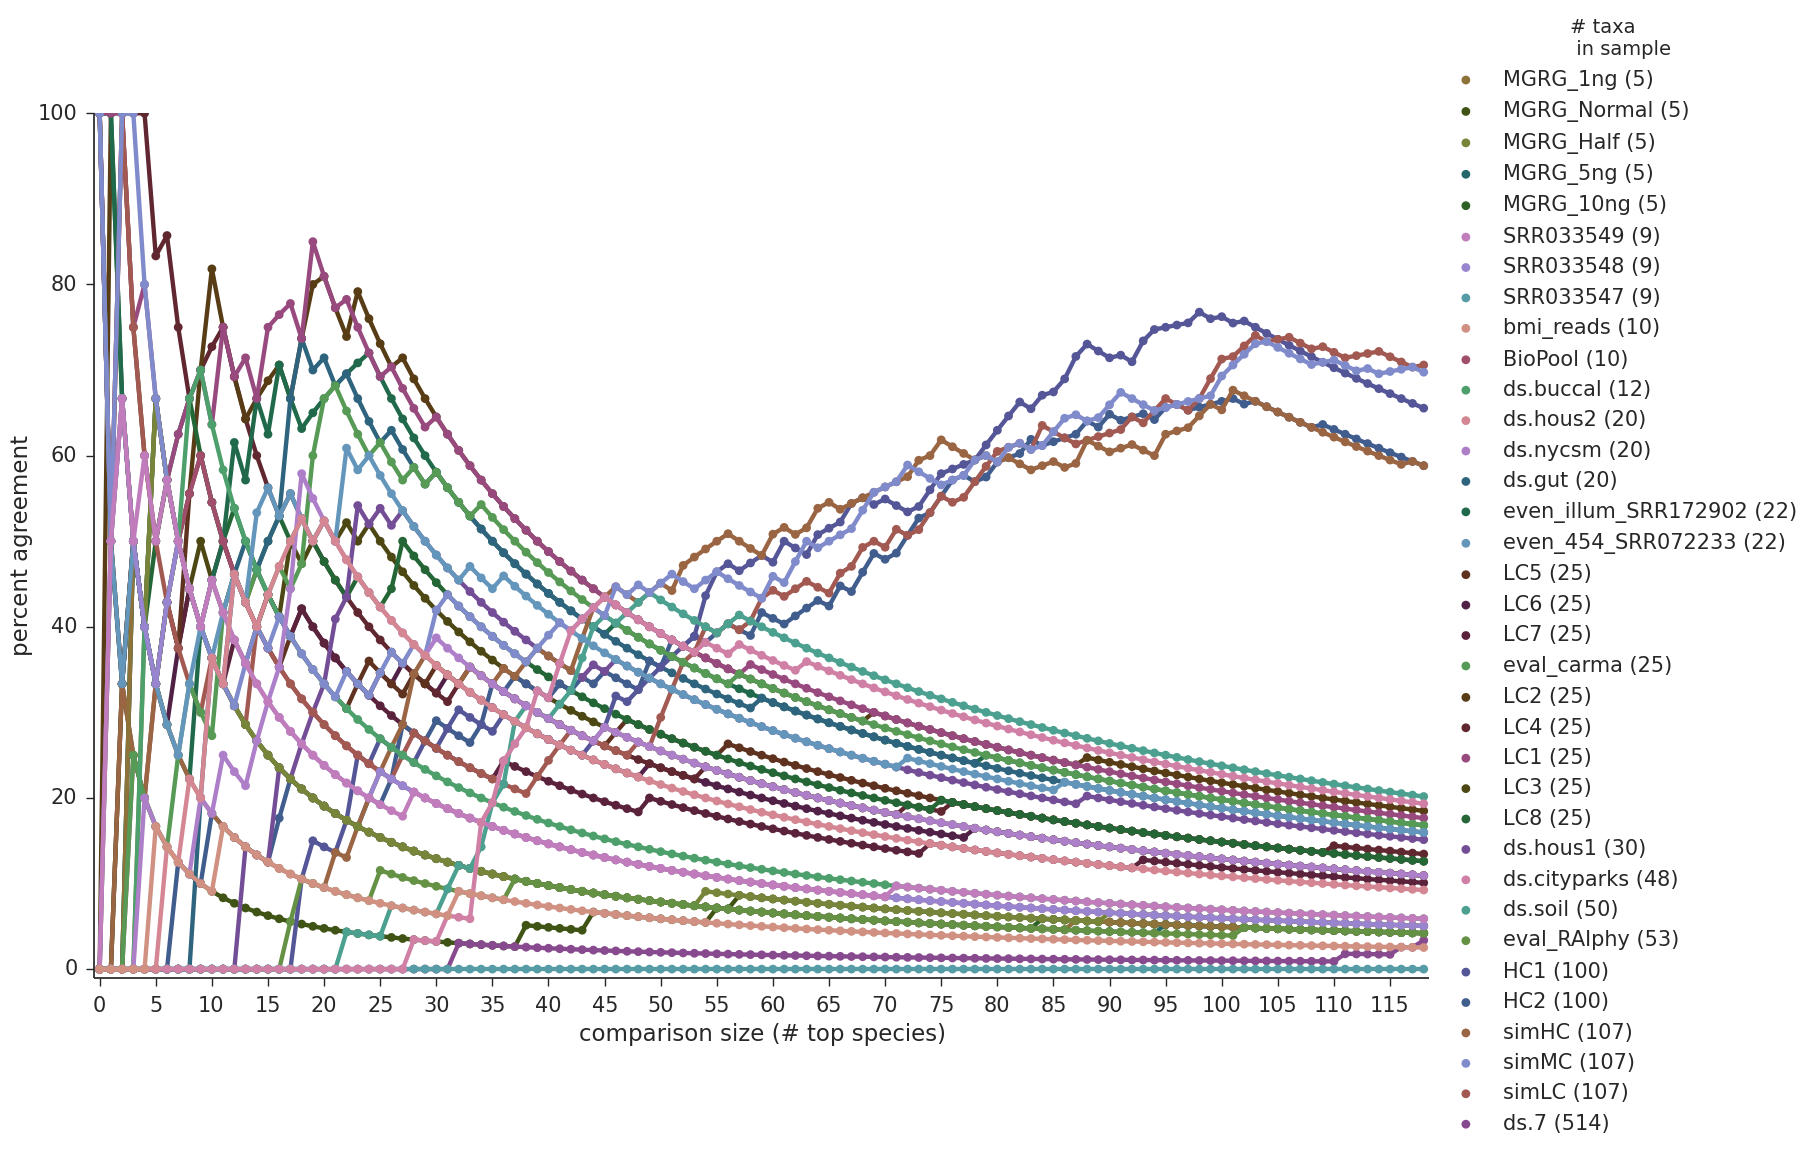

In [25]:
lev,level=1,'species'
top_tools = ['BlastMegan_filtered','DiamondMegan_filtered','MetaPhlAn','GOTTCHA','Kraken_filtered'] 
imprecise_tools = ['CLARK','LMAT','Kraken','NBC','PhyloSift']
agree_df,tool_dict = find_agreement(imprecise_tools,fis,top_tools)
plot_percent_agreement(agree_df,level)

Ensemble prediction of number of species:
R value = 0.961265913419 , p value = 1.78715272376e-19 , RMSE = 8.88819441732

Individual tools:


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Kraken_filtered 0.997074995447 0.0 3.16692465409
MetaPhlAn 0.465780876176 4.68004352665e-217 32.9036025204
DiamondMegan_filtered 0.951236692731 0.0 12.1945021363
GOTTCHA 0.996240893876 0.0 3.8994720608
BlastMegan_filtered 0.995986119197 0.0 3.83098819996


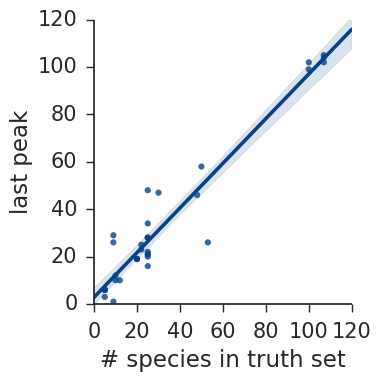

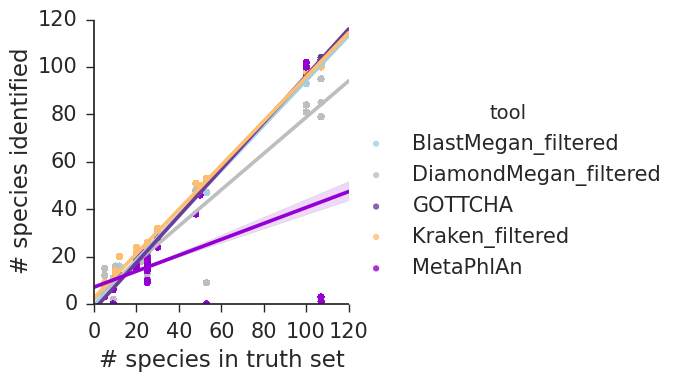

In [26]:
print 'Ensemble prediction of number of species:'
plot_last_peak(agree_df)
print '\nIndividual tools:'
plot_num_hits(tool_dict)

In [56]:
ds = 'eval_RAIphy'
write_venn(fis[ds],imprecise_tools+['truth_set'],len(fis[ds]['truth_set']),'venn_'+ds)
write_venn(fis[ds],imprecise_tools+['truth_set'],len(fis[ds]['truth_set'])*2,'venn_'+ds)
write_venn(fis[ds],imprecise_tools+['truth_set'],len(fis[ds]['truth_set'])/2,'venn_'+ds)

('CLARK',) 53
('LMAT',) 53
('Kraken',) 53
('NBC',) 53
('PhyloSift',) 53
('truth_set',) 53
('CLARK', 'LMAT') 44
('CLARK', 'Kraken') 23
('CLARK', 'NBC') 15
('CLARK', 'PhyloSift') 2
('CLARK', 'truth_set') 44
('LMAT', 'Kraken') 24
('LMAT', 'NBC') 16
('LMAT', 'PhyloSift') 2
('LMAT', 'truth_set') 48
('Kraken', 'NBC') 16
('Kraken', 'PhyloSift') 3
('Kraken', 'truth_set') 27
('NBC', 'PhyloSift') 1
('NBC', 'truth_set') 16
('PhyloSift', 'truth_set') 2
('CLARK', 'LMAT', 'Kraken') 22
('CLARK', 'LMAT', 'NBC') 15
('CLARK', 'LMAT', 'PhyloSift') 2
('CLARK', 'LMAT', 'truth_set') 43
('CLARK', 'Kraken', 'NBC') 15
('CLARK', 'Kraken', 'PhyloSift') 2
('CLARK', 'Kraken', 'truth_set') 23
('CLARK', 'NBC', 'PhyloSift') 1
('CLARK', 'NBC', 'truth_set') 15
('CLARK', 'PhyloSift', 'truth_set') 2
('LMAT', 'Kraken', 'NBC') 16
('LMAT', 'Kraken', 'PhyloSift') 2
('LMAT', 'Kraken', 'truth_set') 23
('LMAT', 'NBC', 'PhyloSift') 1
('LMAT', 'NBC', 'truth_set') 16
('LMAT', 'PhyloSift', 'truth_set') 2
('Kraken', 'NBC', 'PhyloSif

## Supplementary Figure 4

In [28]:
tool_list = lot
level = 'species'
sample_type = 'nanopore'
datasets = ['pass*2d','fail*2d']
fis = load_fis(datasets,file_dict,level,sample_type,-10)
for ds in fis:
    del fis[ds]['MetaFlow']
    del fis[ds]['GOTTCHA-strain']
    del fis[ds]['Community']
    fis[ds]['truth_set'] = tabulate(glob.glob(univ_pref+level+'/*MGRG*TRUTH*')[0],2)
pltdct = {'dataset':[],'ds_num':[],'tool':[],'measure':[],'value':[],'percent_correct':[]} 
for ds in fis:
    truth_set = set(fis[ds]['truth_set'].taxid)
    for tool in fis[ds]:
        if tool != 'truth_set':
            df = fis[ds][tool]
            tot = sum(df.num)
            if tot > 0:
                pc = sum(df.num[df.taxid.isin(truth_set)])*1./tot
                sensitivity = len(df[df.taxid.isin(truth_set)])*1./len(truth_set)
                top_df = df.head(len(truth_set))
                top = len(top_df[top_df.taxid.isin(truth_set)])*1./len(truth_set)
            else:
                pc = 0
                sensitivity = 0 
                top = 0
            pltdct['dataset'].append(ds)
            pltdct['dataset'].append(ds)
            pltdct['dataset'].append(ds)
            pltdct['tool'].append(tool)
            pltdct['tool'].append(tool)
            pltdct['tool'].append(tool)
            pltdct['percent_correct'].append(pc*100)
            pltdct['percent_correct'].append(pc*100)
            pltdct['percent_correct'].append(pc*100)
            pltdct['measure'].append('Recall')
            pltdct['measure'].append('Classifications correct by abundance')
            pltdct['measure'].append('Top 5 taxa correct')
            pltdct['value'].append(sensitivity*100)
            pltdct['value'].append(pc*100)
            pltdct['value'].append(top*100)
            
            if ds == "fail*2d":
                pltdct['ds_num'].append(2)
                pltdct['ds_num'].append(2)
                pltdct['ds_num'].append(2)
            else:
                pltdct['ds_num'].append(1)
                pltdct['ds_num'].append(1)
                pltdct['ds_num'].append(1)
nanodf = pd.DataFrame(pltdct)
#print pltdf.sort_values(['ds_num','percent_correct'],ascending=[True,False])

no truth: []
truth: ['pass*2d', 'fail*2d']


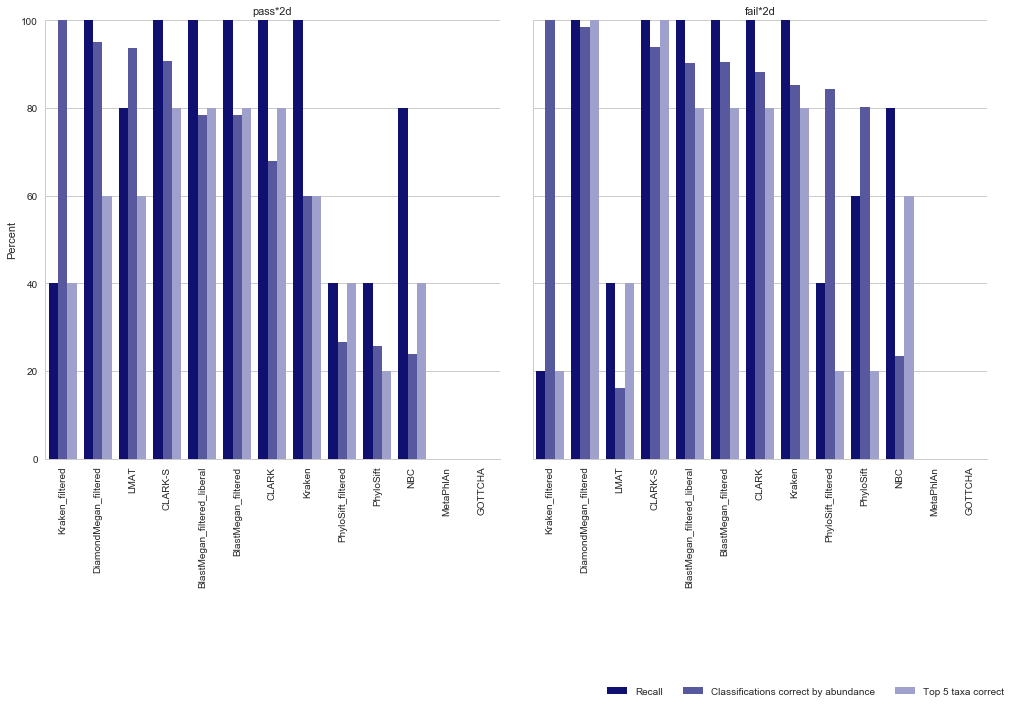

In [29]:
sns.set_style("whitegrid")
g = sns.factorplot(x='tool',y='value',hue='measure',col='dataset',
                   data=nanodf.sort_values(['ds_num','percent_correct'],
                                          ascending=[True,False]),
                   col_order=["pass*2d","fail*2d"],kind='bar',
                   palette=sns.light_palette("navy", 4, reverse=True),size=7,aspect=1,legend=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.6, -0.5),
          ncol=3, fancybox=True, shadow=True)
#print pltdf[pltdf.dataset == 'fail*2d'].sort_values(['ds_num','percent_correct'],ascending=[True,False]).tool
xticklabs = nanodf[(nanodf.dataset =='pass*2d') & (nanodf.measure =='Classifications correct by abundance')].sort_values('percent_correct',ascending=False).tool
(g.set_axis_labels("", "Percent")
    .set_xticklabels(list(xticklabs), rotation=90)
    .set_titles("{col_name}")
    .set(ylim=(0, 100)))
fig = plt.gcf()
save_figtypes(fig,'nanopore_percent_correct_sensitivity_'+level)

# Negative control/pus analylsis

In [118]:
tool_list = lot
sample_type = 'negative_control'

for levels,datasets in zip([['species'],['genus','species']],[['LM','MH1','MH2'],['SL126486','SL126487','SL126488']]):
    cross_dataset_comp = {}
    for level in levels:
        cross_dataset_comp[level] = {}
        fis = load_fis(datasets,file_dict,level,sample_type)
        tool_list = lot 
        
        for ds in fis:
            print ds
            for tool in fis[ds]:
                df = fis[ds][tool]
                #print tool, len(df)
                if len(df) > 0:
                    if tool not in cross_dataset_comp[level]:
                        cross_dataset_comp[level][tool] = {'shannon_i':[],'df':[],'human':[],'percent_human':[]}
                    df.percent = df.num*1. / sum(df.num[df.taxid != '9606'])
                    #print df
                    #if len(df[df.taxid == '9606']) > 0:
                    #    print df[df.taxid == '9606']

                    #print [p for p in df.percent[df.taxid != '9606']]
                    #print [-p*np.log(p) for p in df.percent[df.taxid != '9606']]
                    shannon_index = sum([-p*np.log(p) for p in df.percent[df.taxid != '9606'] if p > 0])
                    #print shannon_index,'\n'
                    cross_dataset_comp[level][tool]['shannon_i'].append(shannon_index)
                    cross_dataset_comp[level][tool]['df'].append(df[df.taxid != '9606'])
                    if len(df[df.taxid == '9606']) > 0:
                        cross_dataset_comp[level][tool]['human'].append(df[df.taxid == '9606'])
                        #print float(df.num[df.taxid == '9606']*1. / sum(df.num))
                        cross_dataset_comp[level][tool]['percent_human'].append(float(df.num[df.taxid == '9606']*1. / sum(df.num)))
                    else:
                        cross_dataset_comp[level][tool]['human'].append([])
                        cross_dataset_comp[level][tool]['percent_human'].append(0)                
                else:
                    print tool, 0        

        print '\n\ttool\tpercent human\tshannon i\tnumber per dataset\tnumber common to all datasets'
        for tool in sorted(cross_dataset_comp[level].keys()):
            ph = np.mean(cross_dataset_comp[level][tool]['percent_human'])
            si = np.mean(cross_dataset_comp[level][tool]['shannon_i'])
            npd = np.mean([len(df) for df in cross_dataset_comp[level][tool]['df']])
            ncd = overlap([list(df.taxid) for df in cross_dataset_comp[level][tool]['df']],[0,1,2])
            print '\t',tool, ph, si, npd, ncd 
        print '\n'

LM
Kraken_filtered 0
OneCodex_filtered 0
BlastMegan_filtered_liberal 0
CLARK 0
BlastMegan_filtered 0
MetaPhlAn 0
GOTTCHA 0
Kraken 0
CLARK-S 0
MetaFlow 0
MH2
Kraken_filtered 0
OneCodex_filtered 0
BlastMegan_filtered_liberal 0
CLARK 0
BlastMegan_filtered 0
MetaPhlAn 0
GOTTCHA 0
Kraken 0
CLARK-S 0
MetaFlow 0
MH1
Kraken_filtered 0
OneCodex_filtered 0
BlastMegan_filtered_liberal 0
CLARK 0
BlastMegan_filtered 0
MetaPhlAn 0
GOTTCHA 0
Kraken 0
CLARK-S 0
MetaFlow 0

	tool	percent human	shannon i	number per dataset	number common to all datasets
	Community 0.0635433934162 4.93373650721 731.333333333 678
	LMAT 0.282800967886 2.79013170948 21.3333333333 0
	NBC 0.0 6.18139151207 678.0 678
	PhyloSift 0.0 2.90201178596 33.6666666667 0
	PhyloSift_filtered 0.0 2.67425267707 20.0 0


SL126486
MetaFlow 0
SL126487
MetaFlow 0
SL126488
MetaFlow 0

	tool	percent human	shannon i	number per dataset	number common to all datasets
	BlastMegan_filtered 0.0 0.0 1.0 1
	BlastMegan_filtered_liberal 0.0 0.00877111763396

In [119]:
replicate_list = []
hits = [] #contaminants for negative controls/hits for pus
for level in ['genus','species']:
    hit_dict = {}
    print '\n',len(high_ppv_overlap_set[level]),'high ppv combinations at the',level,'level'

    for subset in itertools.combinations(tool_list, 2):
        pair = '+'.join(sorted([tool for tool in subset]))
        if pair in high_ppv_overlap_set[level] and subset[0] in cross_dataset_comp[level] and subset[1] in cross_dataset_comp[level]:
            if sample_type == 'negative_control' and len(cross_dataset_comp[level][subset[0]]['df']) == 3 and len(cross_dataset_comp[level][subset[1]]['df']) == 3:
                ov_tool1, ovset_tool1 = overlap([df.taxid for df in cross_dataset_comp[level][subset[0]]['df']],[0,1,2],True)
                #print ov_tool1,len(ovset_tool1),subset[0]
                #break
                ov_tool2, ovset_tool2 = overlap([df.taxid for df in cross_dataset_comp[level][subset[1]]['df']],[0,1,2],True)
                #print ov_tool2,subset[1]
                ov,ov_set = overlap([ovset_tool1,ovset_tool2],[0,1],True)
                print pair, ov_set, ov
                replicate_list.append(ovset_tool1)
                replicate_list.append(ovset_tool2)
                int_hits =  [int(x) for x in ov_set]
                hits = hits + int_hits
                for hit in int_hits:
                    if hit not in hit_dict:
                        hit_dict[hit] = set([subset[0],subset[1]])
                    else:
                        hit_dict[hit].add(subset[0])
                        hit_dict[hit].add(subset[1])
            elif sample_type == 'negative_control':
                print pair, '< 3 replicates'
            
    for hit in hit_dict:
        if len(hit_dict[hit])>2:
            print hit,hit_dict[hit]

#print [int(x) for x in contaminants]


17 high ppv combinations at the genus level
BlastMegan_filtered+PhyloSift_filtered set(['9605']) 1
GOTTCHA+PhyloSift_filtered set(['561', '469']) 2
BlastMegan_filtered+Kraken_filtered set([]) 0
GOTTCHA+Kraken_filtered set(['561', '469']) 2
BlastMegan_filtered+OneCodex_filtered set([]) 0
GOTTCHA+OneCodex_filtered set(['561', '469']) 2
BlastMegan_filtered+CLARK set([]) 0
CLARK+GOTTCHA set(['561', '469']) 2
BlastMegan_filtered+GOTTCHA set([]) 0
BlastMegan_filtered+CLARK-S set([]) 0
BlastMegan_filtered+DiamondMegan_filtered set(['9605']) 1
BlastMegan_filtered+LMAT set(['9605']) 1
CLARK-S+GOTTCHA set(['561', '469']) 2
DiamondMegan_filtered+GOTTCHA set([]) 0
GOTTCHA+LMAT set(['561', '469']) 2
561 set(['PhyloSift_filtered', 'Kraken_filtered', 'OneCodex_filtered', 'CLARK', 'GOTTCHA', 'CLARK-S', 'LMAT'])
9605 set(['PhyloSift_filtered', 'DiamondMegan_filtered', 'LMAT', 'BlastMegan_filtered'])
469 set(['PhyloSift_filtered', 'Kraken_filtered', 'OneCodex_filtered', 'CLARK', 'GOTTCHA', 'CLARK-S', '

In [120]:
print high_ppv_overlap_set['species']

set(['BlastMegan_filtered+GOTTCHA', 'BlastMegan_filtered+OneCodex_filtered', 'GOTTCHA+OneCodex_filtered', 'BlastMegan_filtered+DiamondMegan_filtered', 'BlastMegan_filtered+NBC', 'DiamondMegan_filtered+GOTTCHA'])


In [86]:
print '\n'.join([str(x) for x in list(set(hits))])

In [83]:
for tool in cross_dataset_comp:
    print tool, cross_dataset_comp[tool]['shannon_i'],[len(x) for x in cross_dataset_comp[tool]['df']]

genus

KeyError: 'shannon_i'

In [ ]:
"""dfdict = {}
tool_list = ['Diamond-MEGAN','CLARK','CLARK-S','CosmosID_filtered',
                    'kraken_filtered','phylosift_filtered','metaphlan','LMAT',
                     'metapalette_specific','onecodex_filtered','BLAST-MEGAN','NBC','truth_set']
for ds in fis:
    print ds
    dfdict[ds] = {}
    for tool in tool_list:
        try: 
            dfdict[ds][tool] = fis[ds][tool][['taxid']]
        except TypeError:
            print tool, fis[ds][tool]
    break
for ds in dfdict:
    #print dfdict[ds]
    pyupset.plot(dfdict[ds], sort_by='size', inters_size_bounds=(1, 400))
    break"""